In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

# Residual Inception blocks

Each Inception block is followed by a filter expansion layer
`(1 × 1 convolution without activation)` which is used for scaling up the dimensionality of the filter bank before the addition to match the depth of the input.

In the case of Inception-ResNet, batch-normalization is used only on top of the traditional layers, but not on top of the summations.

---



According to the authors, if the number of filters exceeded 1000, the residual variants started to exhibit instabilities and the network has just “died” early in the training, meaning that the last layer before the average pooling started to produce only zeros after a few tens of thousands of iterations. This could not be prevented, neither by lowering the learning rate, nor by adding an extra batchnormalization to this layer.

According to them, scaling down the residuals before adding them to the previous layer activation seemed to stabilize the training. To scale the residuals, scaling factors between 0.1 and 0.3 were picked.


In [4]:
img_input = Input(shape=(200,200,3))

branch0 = Conv2D(64, (1,1), padding='same', name='Branch_Zero_1_by_1_Conv2D')(img_input)

branch1 = Conv2D(64, (1,1), activation='relu', padding='same', name='BranchOne3By3Conv2D1')(img_input)
branch1 = Conv2D(64, (3,3), activation='relu', padding='same', name='BranchOne3By3Conv2D2')(branch1)
branch1 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='BranchOne3By3Conv2D3')(branch1)

concatenated_branchA = Concatenate()([branch0, branch1])

pool0 = MaxPooling2D(pool_size=(2, 2))(concatenated_branchA)

branch00 = Conv2D(64, (1,1), padding='same', name='BranchZeroZero1By1Conv2D')(pool0)

branch11 = Conv2D(64, (1,1), activation='relu', padding='same', name='BranchOneOne3By3Conv2D1')(pool0)
branch11 = Conv2D(64, (3,3), activation='relu', padding='same', name='BranchOneOne3By3Conv2D2')(branch11)
branch11 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='BranchOneOne3By3Conv2D3')(branch11)

concatenated_branchB = Concatenate()([branch00, branch11])

flattened_before_dense = Flatten()(concatenated_branchB)
dense1 = Dense(1024, activation='relu', name='firstDenseLayer')(flattened_before_dense)
dense2 = Dense(512, activation='relu', name='SecondDenseLayer')(dense1)
prediction_branch = Dense(84,activation='softmax', name='FinalSoftmaxLayer')(dense2)

model = Model(inputs=img_input, outputs=prediction_branch)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
BranchOne3By3Conv2D1 (Conv2D)   (None, 200, 200, 64) 256         input_3[0][0]                    
__________________________________________________________________________________________________
BranchOne3By3Conv2D2 (Conv2D)   (None, 200, 200, 64) 36928       BranchOne3By3Conv2D1[0][0]       
__________________________________________________________________________________________________
Branch_Zero_1_by_1_Conv2D (Conv (None, 200, 200, 64) 256         input_3[0][0]                    
____________________________________________________________________________________________

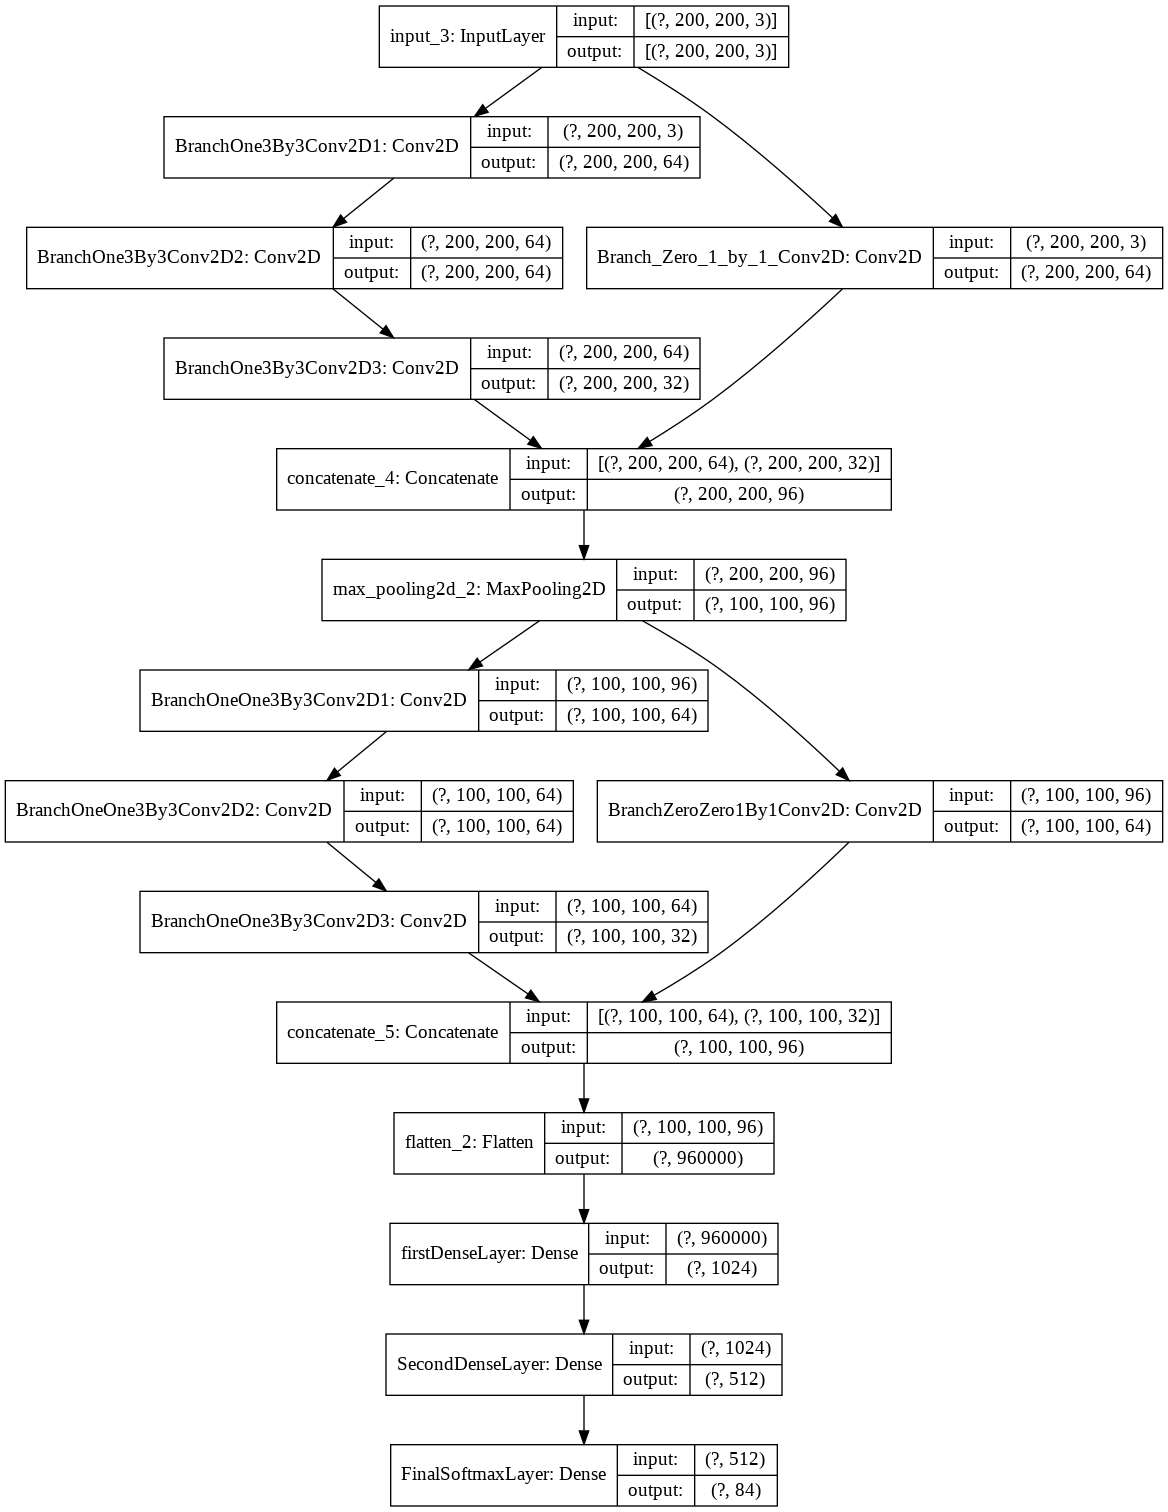

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model , '_AKHCRNetV1_.png' , show_shapes=True)